#### _[NN HW3](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/03-cnn/cnn-architectures/HomeWork.ipynb)_

### _imports_ 

In [1]:
from matplotlib.pylab import plt
%matplotlib inline
from PIL import Image
from io import BytesIO
import requests, os, csv, urllib
import numpy as np

In [2]:
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, classification_report,
                             roc_curve, precision_recall_curve)

In [3]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

Using TensorFlow backend.


## 1. Загрузка изображений

Сохраним файлы с картинками локально, чтобы потом можно было сосредоточиться на настройке модели.

In [4]:
def make_img_name(url):
    return urllib.parse.unquote(url).split('?')[0].split('/')[-1]

def download_images(img_class_name):
    images = list()
    with open(f'{img_class_name}.csv') as csvfile:
        reader = csv.reader(csvfile)
        os.makedirs(img_class_name, exist_ok=True)

        for line in reader:
            url = line[0]
            img_name = make_img_name(url)
            if os.path.exists(os.path.join(img_class_name, img_name)): # trying not to load twice
                continue

            try:
                response = requests.get(url)
                if 200 != response.status_code: 
                    continue
                img_bytes = BytesIO(response.content)
                img_name = make_img_name(response.url)
                if img_name == img_name.split('.')[-1]:
                    img_name = f"{img_name}.{response.headers['Content-Type'].split(';')[0].split('/')[-1]}"
            except Exception as e:
#                 print(type(e), url, e)
                continue

            try:
                img_path = os.path.join(img_class_name, img_name)
                Image.open(img_bytes).verify()
                img = Image.open(img_bytes) # need to reopen after verify()
                img.save(img_path)
                images.append(img_path)
            except Exception as e:
#                 print(type(e), img_path, e)
                if os.path.exists(img_path):
                    os.remove(img_path)

    return images

Будем пытаться классифицировать _Хохлому_ и _Гжель_.

In [5]:
download_images('khokhloma');

In [6]:
download_images('gzhel');

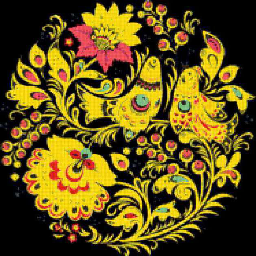

In [7]:
Image.open('khokhloma/hohlomskaya_rospis_21_10094511.jpg').resize(size=(256,256))

## 2. Подготовка данных



Трансформируем изображения в тензоры `256 x 256 x 3`, а также разметим их в соответствии с классом.

Файлы формата **.png** содержат 4 цветовых канала, для простоты я решил их отбросить.

In [8]:
def load_data(img_class_names, size=256):
    x = np.empty(0).reshape(0, size, size, 3)
    y = np.empty(0).reshape(0, 1)
    for class_label, img_class_name in enumerate(img_class_names): 
        join_path = np.vectorize(os.path.join)
        img_files = join_path(img_class_name, np.array(os.listdir(img_class_name)))
        img_files = img_files[[not os.path.isdir(f) for f in img_files]]
        img = [ np.array(Image.open(f).resize(size=(size, size))) for f in img_files ]
        img = np.array([ x for x in img if len(x.shape) == 3 and x.shape[2] == 3 ]) # so far simply taking images with 3 color channels only
        x = np.vstack((x, img))
        y = np.vstack((y, np.full((img.shape[0], 1), class_label, dtype=np.int)))

    return x, y

In [9]:
X, y = load_data(['gzhel', 'khokhloma'])

X /= 255.

X.shape, y.shape, np.unique(y, return_counts=True)

((502, 256, 256, 3),
 (502, 1),
 (array([0., 1.]), array([272, 230], dtype=int64)))

[Сохраним](https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html) подготовленные данные в файлы в формате _numpy_, чтобы при необходимости потом можно было бы начать с этого места.

In [10]:
np.save('images.npy', X)
np.save('labels.npy', y)

## 3. Модель 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.25, random_state=199)

[ x.shape for x in [X_train, X_test, y_train, y_test] ]

[(376, 256, 256, 3), (126, 256, 256, 3), (376, 1), (126, 1)]

In [13]:
model = Sequential([
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Train on 376 samples, validate on 126 samples
Epoch 1/5
376/376 [==============================] - 137s 364ms/step - loss: 2.1742 - acc: 0.6277 - val_loss: 0.4974 - val_acc: 0.7778
Epoch 2/5
376/376 [==============================] - 136s 362ms/step - loss: 0.3627 - acc: 0.8511 - val_loss: 0.3397 - val_acc: 0.9048
Epoch 3/5
376/376 [==============================] - 136s 361ms/step - loss: 0.2232 - acc: 0.9149 - val_loss: 0.2369 - val_acc: 0.9048
Epoch 4/5
376/376 [==============================] - 136s 362ms/step - loss: 0.2624 - acc: 0.9255 - val_loss: 0.2578 - val_acc: 0.8810
Epoch 5/5
376/376 [==============================] - 136s 363ms/step - loss: 0.1758 - acc: 0.9388 - val_loss: 0.2349 - val_acc: 0.9127


## 4. Проверка качества модели

In [14]:
model.evaluate(X_test, y_test)

126/126 [==============================] - 12s 92ms/step


[0.23492091633970774, 0.9126984070217798]

In [15]:
y_probs = model.predict_proba(X_test)
y_pred = (y_probs.flatten() > 0.5) * 1

In [16]:
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92        68
         1.0       0.93      0.88      0.90        58

   micro avg       0.91      0.91      0.91       126
   macro avg       0.91      0.91      0.91       126
weighted avg       0.91      0.91      0.91       126



In [17]:
def plot_curve_xy(x, y):    
    plt.plot(x, y, lw=3)

def plot_curve(nrc, curve, y_test, y_probs, title, xlabel, ylabel):
    plt.subplot(nrc)
    auc = curve(y_test, y_probs)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'{title} AUC={auc:.3f}')
    plt.grid()

def plot_roc_curve(y_test, y_probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plot_curve_xy(fpr, tpr)
    return sklearn.metrics.auc(fpr, tpr)

def plot_pr_curve(y_test, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    plot_curve_xy(recall, precision)
    return sklearn.metrics.auc(recall, precision)

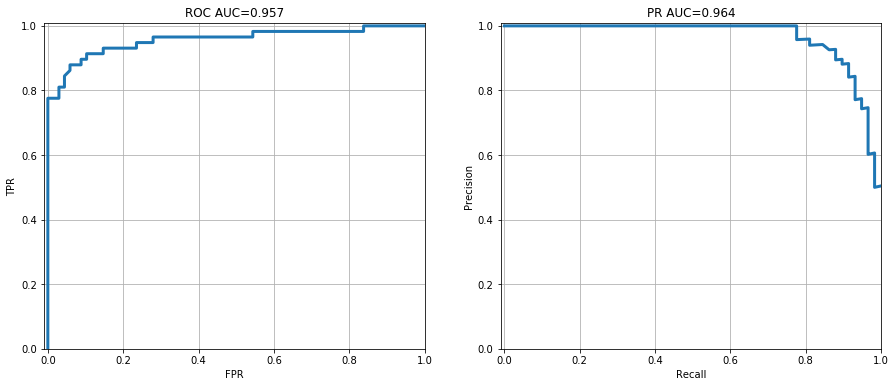

In [18]:
plt.figure(figsize=(15, 6))

plot_curve(121, plot_roc_curve, y_test, y_probs, 'ROC', 'FPR', 'TPR')
plot_curve(122, plot_pr_curve, y_test, y_probs, 'PR', 'Recall', 'Precision')

plt.show();

Как можно видеть, даже такая относительно простая структура нейросети позволяет делать довольно точные предсказания на выбранном датасете. Возможно, это объясняется тем, что изображения сильно отличаются по цветовой гамме, поэтому даже наличие некоторого количества "мусорных" изображений (на которых не сами изделия, а что-то постороннее) практически не повлияло на качество.

Но при этом уже более амбициозная задача - классификация _Хохлома_ vs _Палехская лаковая миниатюра_, для данной сети оказывается слишком сложной) 